[View in Colaboratory](https://colab.research.google.com/github/tcglarry/alibaba_manufacturing_competition/blob/master/ali_build_model_stage_2_MobileNetV2_aug.ipynb)

In [1]:

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse



gpg: keybox '/tmp/tmpixdxu5ph/pubring.gpg' created
gpg: /tmp/tmpixdxu5ph/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
E: Unable to locate package google-drive-ocamlfuse


In [2]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

!pip install --upgrade keras
!pip install --upgrade tensorflow

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.2.3)
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.11.0)


In [4]:

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import subprocess
import os
import pickle
import sklearn

from sklearn.model_selection import train_test_split

from xgboost.sklearn import XGBClassifier




import keras.backend as K

from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
#from keras.applications.mobilenet import MobileNet
#from keras.applications.mobilenetv2 import MobileNetV2
#from keras.applications.nasnet import NASNetMobile,NASNetLarge
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,  img_to_array, load_img



from keras.applications.xception import Xception, preprocess_input

from keras.layers import Dense, GlobalAveragePooling2D,Flatten, BatchNormalization
from keras.layers import Input, Conv2D, MaxPooling2D, merge, Lambda,UpSampling2D, concatenate, Reshape, Dropout,Cropping2D,Activation
from keras.models import Model, load_model
import pandas as pd

from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import Callback


from keras import regularizers
#from dummyPy import OneHotEncoder
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix

import itertools
import time


Using TensorFlow backend.


In [0]:
src_1= 'drive/My Drive/kaggle/ali/new_era/'
src_2= 'train_sample_total/' #'train data directory'
src_3 = 'guangdong_round1_test_a_20180916/'  # test data directory
src_save = 'drive/My Drive/kaggle/ali/new_era/'

In [0]:









with open(src_1+'train_file_list.pkl', 'rb') as handle:
    file_list = pickle.load(handle)
file_list







with open(src_1+'failure_to_label.pkl', 'rb') as handle:
    label_dict = pickle.load(handle)
label_dict


'''
get first stage train data
'''

#train1_data = np.load(src_save+'train_data_DenseNet121_1_verification.npy')
train1_data = np.load(src_1+'train_data_MobileNetV2_1.npy')
print (train1_data.shape)



'''
1st stage label data if normal(which means categhory 0) , label 1
else: label 0
'''

#with open (src_save+'train_label_data_verification.pkl','rb') as handle:
with open (src_1+'train_label_data.pkl','rb') as handle:
    train_label_data = pickle.load(handle)
train_label_data.shape

train_label_data_0 =  (train_label_data == 0) * 1


print (train_label_data_0.shape)




'''
build 1st stage model
'''

train_x,val_x,train_y,val_y = train_test_split(train1_data,train_label_data_0,test_size=0.2,shuffle=True)


xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb1.fit(train_x,train_y)


from sklearn.metrics import accuracy_score
val_pred = xgb1.predict(val_x)

predictions = [round(value) for value in val_pred]
# evaluate predictions
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [23]:

test1_data = np.load(src_1+'test_data_MobileNetV2_1.npy')

test_pred = xgb1.predict(test1_data)
predictions = [round(value) for value in test_pred]
print (predictions[:10])

[1, 1, 0, 1, 0, 1, 0, 0, 1, 0]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [25]:
with open (src_1+'xgb_2_stage_MobileNetV2_1_0926.pkl','wb') as handle:
  pickle.dump(xgb1,handle)
print ('xgb saved')  

xgb saved


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[291   4]
 [  9 174]]






             precision    recall  f1-score   support

          0       0.97      0.99      0.98       295
          1       0.98      0.95      0.96       183

avg / total       0.97      0.97      0.97       478






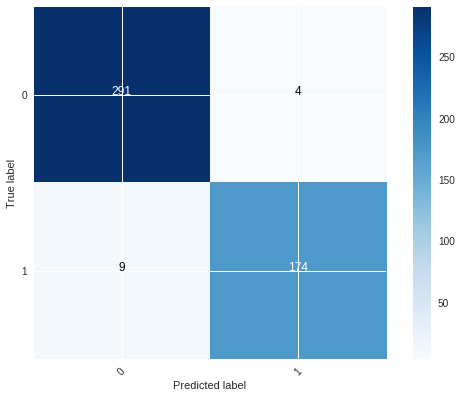

In [29]:

class_names = [i for i in range (2)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
  
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''    
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:


cnf_matrix = confusion_matrix(val_y, xgb1.predict(val_x))


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(val_y,xgb1.predict(val_x)))
print ('\n\n')

# Start building 2nd stage model 

In [8]:


'''
build 2nd stage model
# 雀屏中選
'''


train2_data = np.load(src_1+'train_data_MobileNetV2_1_aug_for_1.npy')
print (train2_data.shape)


'''
filter out defcet item from label
get  2nd stage train data and label data note: 2nd stage tarin data will use conv

'''





with open (src_1+'train_label_data_aug_for_1.pkl','rb') as handle:
    train_label_data = pickle.load(handle)
  


#train_x,val_x,train_y,val_y = train_test_split(train2_data,train_label_data,test_size=0.2,shuffle=True)

#print (train_x.shape)


'''  

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)



  
xgb1.fit(train_x,train_y)


from sklearn.metrics import accuracy_score
val_pred = xgb1.predict(val_x)

predictions = [round(value) for value in val_pred]
# evaluate predictions
accuracy = accuracy_score(val_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
  
'''  
  

one_hot_train_label_data = to_categorical(train_label_data - 1)

print (one_hot_train_label_data.shape)







(17411, 1000)
(17411, 11)


NameError: ignored

In [10]:

train_x,val_x,train_y,val_y = train_test_split(train2_data,one_hot_train_label_data,test_size=0.2,shuffle=True)

# NOW Data ready for training

print (train_x.shape)


def conv_block(ch, strides, activation= 'relu', padding='same',kernel_regularizer=regularizers.l1(0.05)):
    return Conv2D(ch,(3,3), strides=strides, activation= activation, padding =padding , kernel_regularizer= kernel_regularizer)

def build_model_6(ch=32):
    #inputs = Input((IMAGE_HEIGHT,IMAGE_WIDTH,ch))
    inputs = Input((1000,))



    x = Dense(256, activation='relu')(inputs)

    x =Dropout(0.3)(x)

    x = Dense(128, activation='relu')(x)

    x =Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)

    x =Dropout(0.3)(x)

    #x = Dense(64, activation='relu')(x)

    #x =Dropout(0.3)(x)


    outputs = Dense(11,activation='softmax')(x)



    model = Model(inputs= inputs, outputs=outputs)
    model.summary()

    return model



model = build_model_6()

model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

#model_6 = load_model(src_1+'conv_for_defect_11_2_final.h5')


checkpoint = ModelCheckpoint(src_save+'conv_for_defect_11_2.h5')
earlystop = EarlyStopping(monitor='val_loss',  patience=10,  mode='auto')
callback_list = [checkpoint,earlystop]

model.fit(x=train_x, y=train_y, batch_size=32, epochs=300, verbose=1,  validation_split=0.2, shuffle=True)

model.evaluate(val_x,val_y)

(13928, 1000)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               256256    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0      

KeyboardInterrupt: ignored

In [13]:
model.evaluate(val_x,val_y)

3483/3483 [==============================] - 0s 53us/step


[0.23189257562348736, 0.9193224232497312]

---

In [0]:

model.save(src_save+'2nd_stage_MobileNetV2_aug_1000_final.h5')


Confusion matrix, without normalization
[[148   0   0   1   1   0   0   0   0   0   8]
 [  0 654   0   1   0   2   0  62   1  12  20]
 [  0   0 198   0   0   0   0   0   0   0   0]
 [  1   2   0 142   0   0   0   1   1   1   1]
 [  1   0   0   2 538   0   0   0   2   0   2]
 [  0   8   0   0   0 314   6   3   0   6   7]
 [  0   0   0   0   0   0  71   0   0   0   0]
 [  0  17   0   0   0   0   0 138   0   0   0]
 [  0   1   0   0   0   0   0   0 151   0   0]
 [  0  21   0   1   0   1   0   1   0 255  16]
 [  6  30   1   1   6   6   0   4   2  15 593]]






             precision    recall  f1-score   support

          0       0.95      0.94      0.94       158
          1       0.89      0.87      0.88       752
          2       0.99      1.00      1.00       198
          3       0.96      0.95      0.96       149
          4       0.99      0.99      0.99       545
          5       0.97      0.91      0.94       344
          6       0.92      1.00      0.96        71
          7

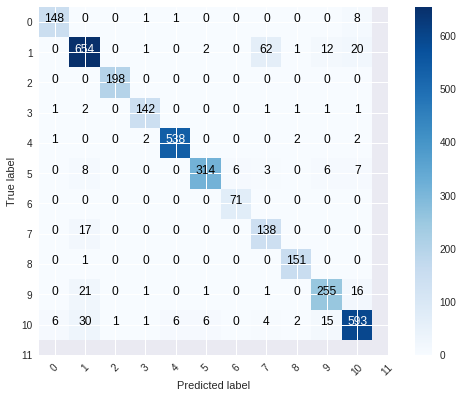

In [16]:

'''
plot confusion matrix
'''
class_names = [i for i in range (12)]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):


    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    '''
    labels = classes
    #cm = confusion_matrix(y_test, pred, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''
    print(cm)
    print ('\n\n')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[ ]:

predictions = np.argmax(model.predict(val_x),axis=1)

cnf_matrix = confusion_matrix(np.argmax(val_y,axis=1), predictions)


# In[ ]:


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names)

from sklearn import metrics
print ('\n\n')
print (metrics.classification_report(np.argmax(val_y,axis=1), predictions))
print ('\n\n')

# Start Testing

In [39]:

"""# Starting doing Testing"""

'''
1st stage
import Data
import ast stage model - xgb
classfiication via xgb1
later wil sue 1st stage classification to filter out test data for 2nd stage classfiication
'''

test1_data = np.load(src_1+'test_data_MobileNetV2_1.npy')



with open (src_1+'xgb_2_stage_MobileNetV2_1_0926.pkl','rb') as handle:
  xgb_stage_1 = pickle.load(handle)


xgb_stage_1



pred_stage_1 = xgb_stage_1.predict(test1_data)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

#print (len(predictions_stage_1))
print (pred_stage_1[:10])

# note: predict = 1 measn '正常' or non-dfect

failure_list= (pred_stage_1 == 0)



test2_data = np.load(src_1+'test_data_MobileNetV2_1.npy')
test2_data.shape


test2_data_2 = test2_data[failure_list]    # test_data2 = defect list in test data set (later will make inferefing )
test2_data_2.shape

model = load_model(src_1+'2nd_stage_dense_MobileNetV2_2_0926.h5')


pred_stage_2 = model.predict(test2_data_2)

#predictions_stage_1 = [round(value) for value in pred_stage_1]

print (pred_stage_2.shape)

pred_stage_2_2 = np.argmax(pred_stage_2,axis=1) + 1  # note 要加  1 回來 starts from 1 to12 (not 0 to 11)
print (pred_stage_2_2.shape)

print (pred_stage_2_2[:10])


'''
make submit csv
read sample test csv  from original add header 'img', 'label'
replace 'label' as first predict
change 0 to 20 (use 20 to distiguish from other label data, just means it is defect
change 1 to 0  (1 measn normal, needs to change back to category 0)
'''

# read test csv file
test_df = pd.read_csv(src_1+'test.csv')
test_df['label']= pred_stage_1
test_df.loc[test_df['label']==0,'label']=20
test_df.loc[test_df['label']==1,'label']=0



'''
replace defect rows with 2nd staget prediction
'''
test_df_2 =  test_df['label']
test_df_2[test_df_2 == 20] = pred_stage_2_2


test_df['label'] = test_df_2


'''
change form 0,11 to category name
'''

with open(src_1+'label_to_category.pkl', 'rb') as handle:
    label_to_category = pickle.load(handle)


test_df['label'].replace(label_to_category,inplace=True)
test_df

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[1 1 0 1 0 1 0 0 1 0]
(313, 11)
(313,)
[ 2 10  9 10  3  6  7  2 10 10]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,img,label
0,0.jpg,norm
1,1.jpg,norm
2,2.jpg,defect2
3,3.jpg,norm
4,4.jpg,defect10
5,5.jpg,norm
6,6.jpg,defect9
7,7.jpg,defect10
8,8.jpg,norm
9,9.jpg,defect3


In [0]:



# save csv file for submit (using 2  satge )

test_df.to_csv(src_1+'test_submit_2_st_0926_no__doubt.csv', header=False,index=False)
